In [26]:
#Basic

import os
import pandas as pd
from glob import glob
import json

# NLP
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
import nltk
import re
from nltk.corpus import stopwords

#Pytorch ML
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import torch.nn.functional as F


# Dataset CLPsych Shared Task (Reddit Depression, Anx, PTSD)

### Combining all the Data into one CSV for further analysis

In [2]:
# Folder containing all TF-IDF CSVs
input_folder = "/Users/saitejasmopuri/Desktop/repos/Chiron/chiron-ai/Datasets/CLpsych/data"
output_folder = input_folder + "/combined-data"
os.makedirs(output_folder, exist_ok=True)

In [3]:
# Where final combined CSV will be saved
output_file = output_folder + "/combined.csv"

In [4]:
# Text column aliases we may find in different datasets
TEXT_COLS = ["post", "body", "text", "selftext", "CONTENT"]

combined = []

csv_files = glob(os.path.join(input_folder, "*.csv"))
print(f"Found {len(csv_files)} CSV files.")

Found 108 CSV files.


In [5]:
for file in csv_files:
    try:
        df = pd.read_csv(file)

        # Extract subreddit name from filename
        subreddit = os.path.basename(file).split("_")[0]
        df["subreddit"] = subreddit

        # Find text column
        text_col = None
        for col in TEXT_COLS:
            if col in df.columns:
                text_col = col
                break

        if text_col is None:
            print(f"⚠️ No text column found in {file}, skipping.")
            continue

        # Ensure required columns exist
        if "author" not in df.columns:
            df["author"] = None
        if "date" not in df.columns:
            df["date"] = None

        # Keep only required columns
        df = df[["subreddit", "author", "date", text_col]]
        df.rename(columns={text_col: "post"}, inplace=True)

        combined.append(df)
        print(f"Processed: {file}")

    except Exception as e:
        print(f"❌ Error processing {file}: {e}")

# Merge all into one DataFrame
if combined:
    final_df = pd.concat(combined, ignore_index=True)
    final_df.drop_duplicates(subset=["author", "date", "post"], inplace=True)
    
    final_df.to_csv(output_file, index=False)
    print(f"\n✅ Combined CSV saved to: {output_file}")
    print(f"Total rows: {len(final_df)}")
else:
    print("❌ No data combined.")

Processed: /Users/saitejasmopuri/Desktop/repos/Chiron/chiron-ai/Datasets/CLpsych/data/guns_pre_features_tfidf_256.csv
Processed: /Users/saitejasmopuri/Desktop/repos/Chiron/chiron-ai/Datasets/CLpsych/data/relationships_2018_features_tfidf_256.csv
Processed: /Users/saitejasmopuri/Desktop/repos/Chiron/chiron-ai/Datasets/CLpsych/data/socialanxiety_post_features_tfidf_256.csv
Processed: /Users/saitejasmopuri/Desktop/repos/Chiron/chiron-ai/Datasets/CLpsych/data/adhd_2018_features_tfidf_256.csv
Processed: /Users/saitejasmopuri/Desktop/repos/Chiron/chiron-ai/Datasets/CLpsych/data/autism_2019_features_tfidf_256.csv
Processed: /Users/saitejasmopuri/Desktop/repos/Chiron/chiron-ai/Datasets/CLpsych/data/teaching_post_features_tfidf_256.csv
Processed: /Users/saitejasmopuri/Desktop/repos/Chiron/chiron-ai/Datasets/CLpsych/data/ptsd_2018_features_tfidf_256.csv
Processed: /Users/saitejasmopuri/Desktop/repos/Chiron/chiron-ai/Datasets/CLpsych/data/suicidewatch_pre_features_tfidf_256.csv
Processed: /Users/

In [6]:

file_path = "/Users/saitejasmopuri/Desktop/repos/Chiron/chiron-ai/Datasets/CLpsych/data/combined-data/combined.csv"

df = pd.read_csv(file_path)

print("Shape:", df.shape)
print(df.head())

Shape: (1044269, 4)
  subreddit              author        date  \
0      guns        TrickyWidget  2019/08/29   
1      guns            Phonkboi  2019/08/29   
2      guns         civildallas  2019/08/29   
3      guns            alphenos  2019/08/29   
4      guns  ThePrince_OfWhales  2019/08/29   

                                                post  
0  Bersa Thunder 22: Long-term reliability? Hi, f...  
1  Anybody have any experience with the diamondba...  
2  Old &amp; New // Colt 1911 &amp; MCX Rattler I...  
3  Start working in a gun shop next week. Need so...  
4  Cheap targets for plinking? I'm headed to the ...  


## EDA

In [7]:
### Lets create a bar plot on the subreddit column

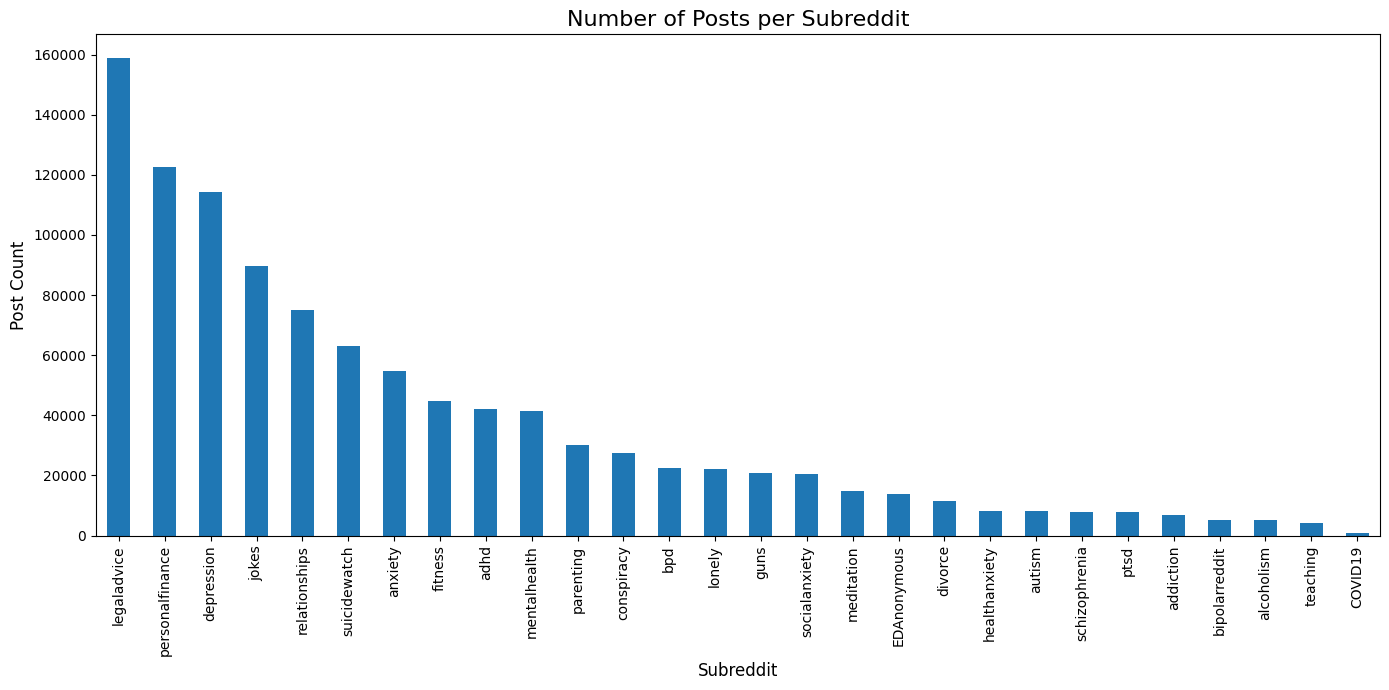

In [8]:
# Count posts per subreddit
subreddit_counts = df['subreddit'].value_counts()

# Create bar plot
plt.figure(figsize=(14, 7))
subreddit_counts.plot(kind='bar')

plt.title("Number of Posts per Subreddit", fontsize=16)
plt.xlabel("Subreddit", fontsize=12)
plt.ylabel("Post Count", fontsize=12)
plt.xticks(rotation=90)
plt.tight_layout()

plt.show()

In [9]:
### EDA where we find the top 20 frequent words used in each sub reddit category and make a word cloud visualization.

In [10]:
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/saitejasmopuri/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
'''

# The subset parameter specifies a list of column labels. 
# dropna() will then only consider missing values within these specified columns when deciding 
# whether to drop a particular row. If a row has a missing value in any of the columns listed in subset

'''

df = df.dropna(subset=["post"])

<Axes: xlabel='subreddit'>

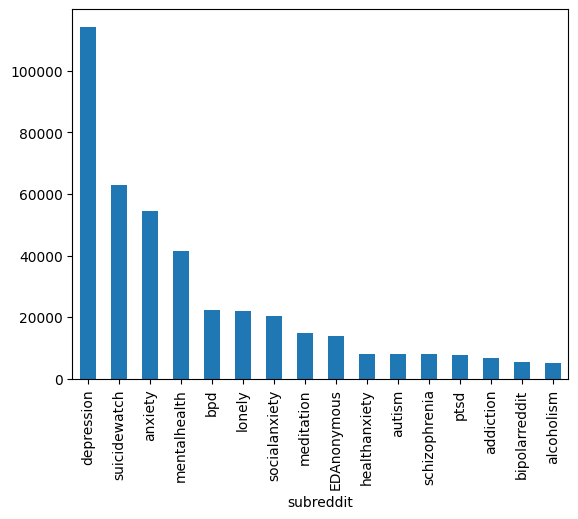

In [12]:
# Cleaner, more focused insight.

df = df[df['subreddit'].isin(["depression","anxiety","suicidewatch","addiction","alcoholism",
                              "bipolarreddit","bpd","ptsd","schizophrenia","autism",
                              "EDAnonymous","lonely","socialanxiety","mentalhealth",
                              "healthanxiety","meditation"])]
df["subreddit"].value_counts().plot(kind="bar")


In [13]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+", "", text)
    text = re.sub(r"[^a-z\s]", " ", text)
    tokens = [w for w in text.split() if w not in stop_words and len(w) > 2]
    return tokens


### Exploring Go Emotions to detect emotions and signals

In [14]:
model_name = "joeddav/distilbert-base-uncased-go-emotions-student"

In [15]:
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Disable gradient calculations for speed
torch.set_grad_enabled(False)

# Get emotion labels
labels = [model.config.id2label[i] for i in range(model.config.num_labels)]
labels

['admiration',
 'amusement',
 'anger',
 'annoyance',
 'approval',
 'caring',
 'confusion',
 'curiosity',
 'desire',
 'disappointment',
 'disapproval',
 'disgust',
 'embarrassment',
 'excitement',
 'fear',
 'gratitude',
 'grief',
 'joy',
 'love',
 'nervousness',
 'optimism',
 'pride',
 'realization',
 'relief',
 'remorse',
 'sadness',
 'surprise',
 'neutral']

In [16]:
def predict_emotions(text):
    tokens = tokenizer(text, return_tensors="pt", truncation=True)
    outputs = model(**tokens)
    probs = torch.sigmoid(outputs.logits).squeeze().tolist()
    return probs


In [17]:
emotion_cols = labels

# Limit dataframe to first 10,000 rows
df_subset = df.head(10000).copy()

# Initialize emotion columns
for label in emotion_cols:
    df_subset[label] = 0.0

# Run emotion prediction
for idx, row in df_subset.iterrows():
    if idx % 500 == 0:
        print(f"Processing row {idx} / {len(df_subset)}")

    probs = predict_emotions(row["post"])
    for i, label in enumerate(emotion_cols):
        df_subset.at[idx, label] = probs[i]

df_subset.head()


Processing row 28000 / 10000
Processing row 28500 / 10000
Processing row 29000 / 10000
Processing row 29500 / 10000
Processing row 30000 / 10000
Processing row 30500 / 10000
Processing row 31000 / 10000
Processing row 36500 / 10000
Processing row 37000 / 10000
Processing row 37500 / 10000
Processing row 39000 / 10000
Processing row 39500 / 10000
Processing row 40000 / 10000
Processing row 40500 / 10000
Processing row 41000 / 10000
Processing row 41500 / 10000
Processing row 42000 / 10000
Processing row 42500 / 10000
Processing row 43000 / 10000
Processing row 43500 / 10000


subreddit            author        date  \
27644  socialanxiety        SyrahIsFat  2020/01/01   
27645  socialanxiety  FuckAUsername420  2020/01/01   
27646  socialanxiety         blakppuch  2020/01/01   
27647  socialanxiety            Jothic  2020/01/01   
27648  socialanxiety    martellen14466  2020/01/01   

                                                    post  admiration  \
27644  sertraline For anxiety Hi basically I have rea...    0.170258   
27645  Do you guys ever feel like you're a different ...    0.465041   
27646  We had visitors and it wasn’t that bad. Over t...    0.327560   
27647  I have social anxiety and anger issues I’ve be...    0.131844   
27648  New year new me HAPPY NEW YEAR!!!\n\n         ...    0.231275   

       amusement     anger  annoyance  approval    caring  ...      love  \
27644   0.112826  0.209765   0.427590  0.427473  0.573860  ...  0.112382   
27645   0.345631  0.236746   0.529976  0.515053  0.725153  ...  0.225023   
27646   0.315480  0.252509   0.461624  0.555428  0.568077  ...  0.173197   
27647   0.082296  0.588108   0.586870  0.445694  0.472678  ...  0.075001   
27648   0.250318  0.174902   0.326826  0.508116  0.639660  ...  0.219618   

       nervousness  optimism     pride  realization    relief   remorse  \
27644     0.940980  0.125716  0.165292     0.486689  0.215284  0.470146   
27645     0.397530  0.361793  0.472100     0.707752  0.510019  0.426507   
27646     0.878878  0.213920  0.271182     0.419213  0.290529  0.603428   
27647     0.900948  0.144398  0.211303     0.498434  0.146028  0.672971   
27648     0.937274  0.360400  0.254530     0.416188  0.362162  0.435537   

        sadness  surprise   neutral  
27644  0.506701  0.297525  0.323210  
27645  0.336150  0.432141  0.816404  
27646  0.410289  0.491972  0.416410  
27647  0.464025  0.295126  0.318911  
27648  0.320053  0.338084  0.309713  

[5 rows x 32 columns]

In [19]:
emotion_top_words = {}

for emotion in emotion_cols:
    weighted_words = []

    for idx, row in df_subset.iterrows():
        tokens = clean_text(row["post"])
        weight = row[emotion]
        weighted_words.extend(tokens * int(weight * 100))

    counter = Counter(weighted_words)
    emotion_top_words[emotion] = counter.most_common(20)

# Print some
emotion_top_words["sadness"], emotion_top_words["anger"], emotion_top_words["fear"]

([('like', 625022),
  ('feel', 488779),
  ('know', 439714),
  ('want', 432863),
  ('people', 424530),
  ('get', 369434),
  ('life', 357235),
  ('really', 310048),
  ('even', 306471),
  ('time', 290771),
  ('would', 264346),
  ('one', 262375),
  ('anxiety', 244013),
  ('think', 236912),
  ('friends', 231429),
  ('going', 216394),
  ('help', 210179),
  ('never', 208125),
  ('much', 199078),
  ('social', 194788)],
 [('like', 412600),
  ('feel', 292203),
  ('people', 289304),
  ('want', 282058),
  ('know', 279427),
  ('get', 249059),
  ('life', 218099),
  ('even', 199364),
  ('really', 195117),
  ('time', 189258),
  ('one', 179787),
  ('would', 176040),
  ('think', 154289),
  ('friends', 144321),
  ('going', 142989),
  ('anxiety', 140221),
  ('never', 133482),
  ('help', 133041),
  ('much', 127413),
  ('years', 114065)],
 [('like', 576672),
  ('feel', 436685),
  ('people', 409487),
  ('know', 389164),
  ('want', 361889),
  ('get', 344652),
  ('anxiety', 308074),
  ('really', 286046),
  ('l

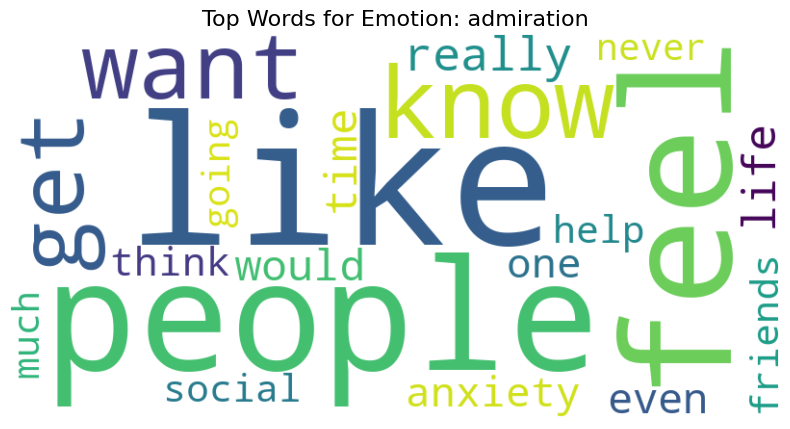

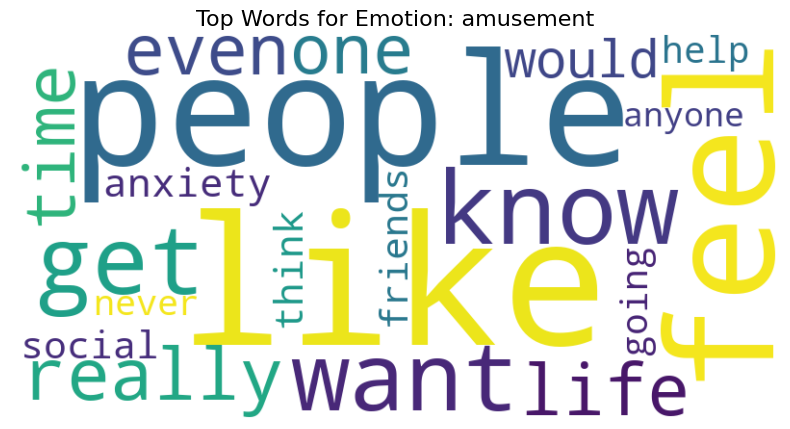

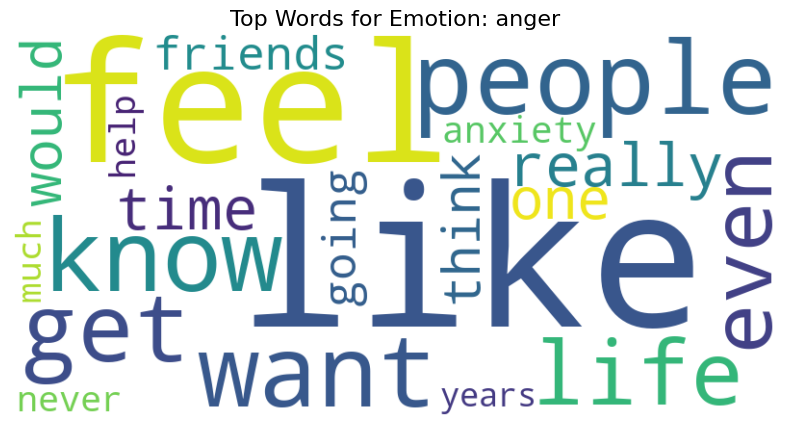

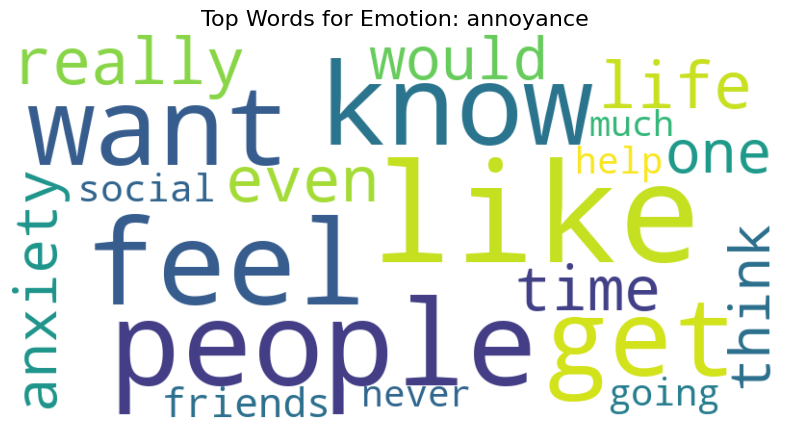

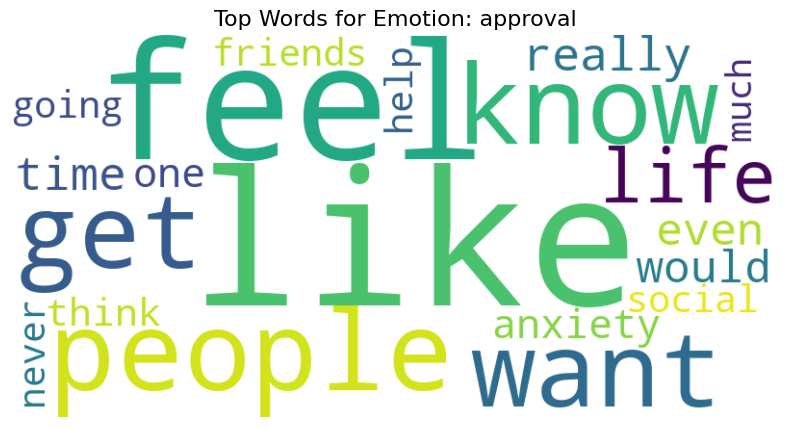

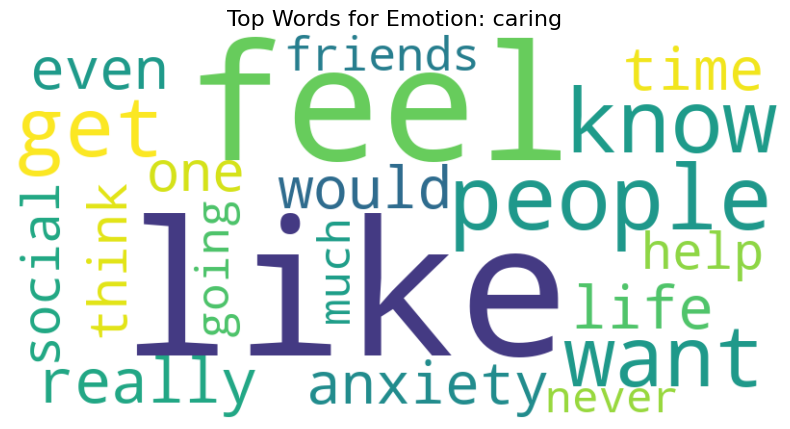

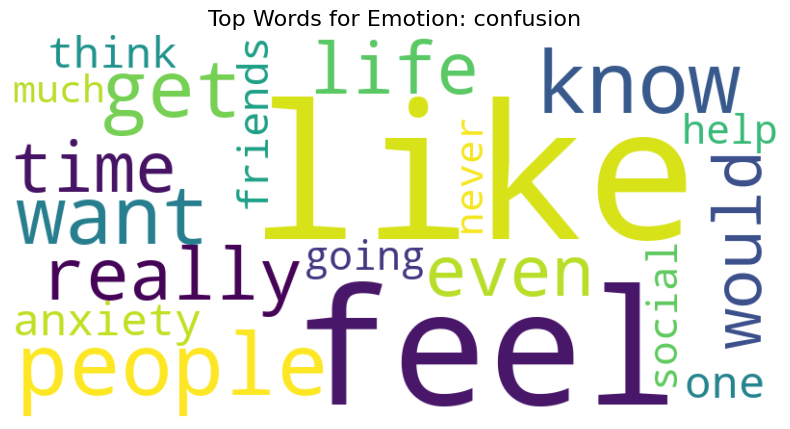

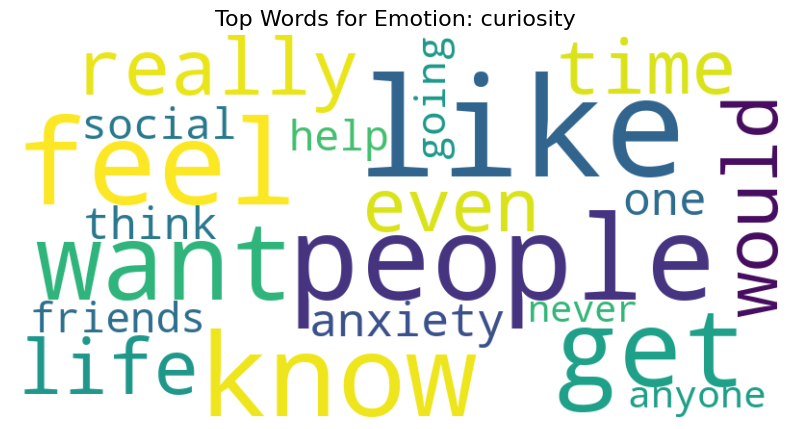

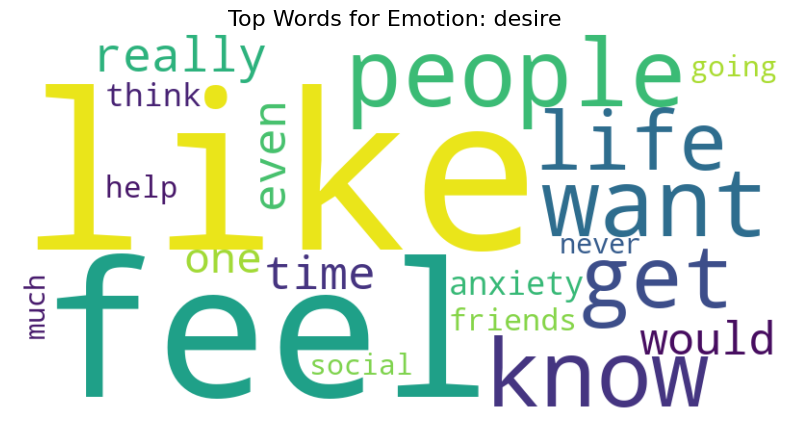

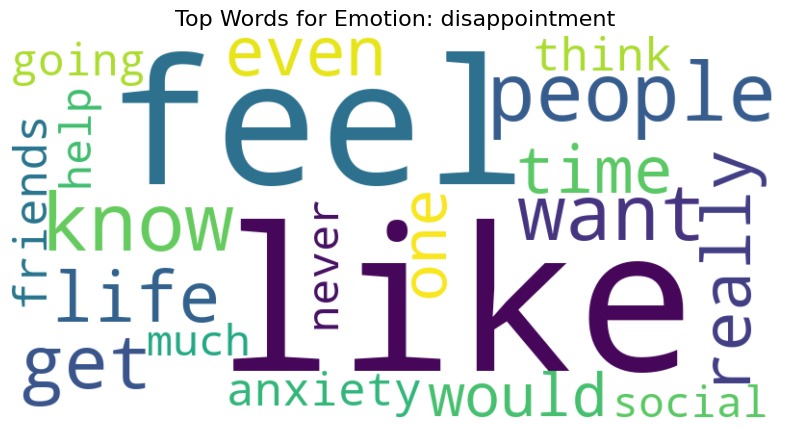

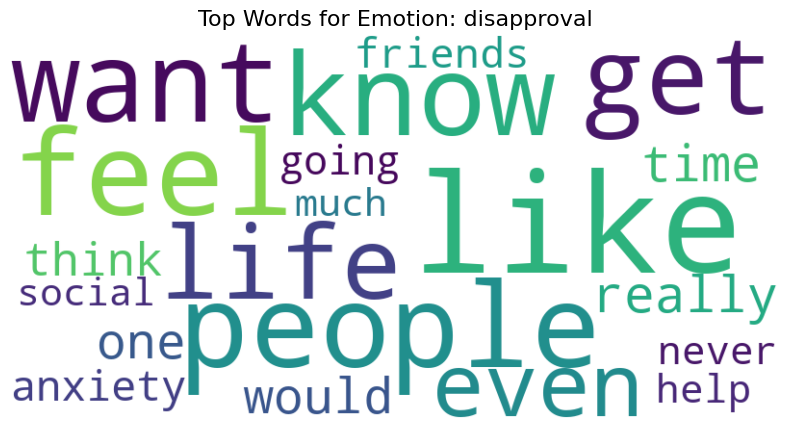

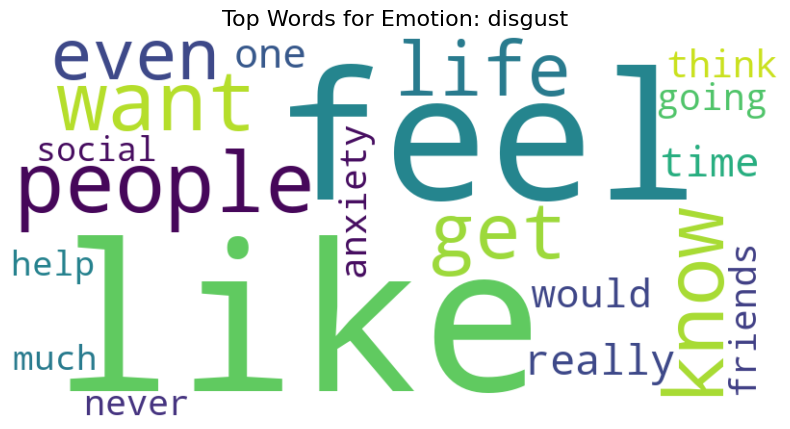

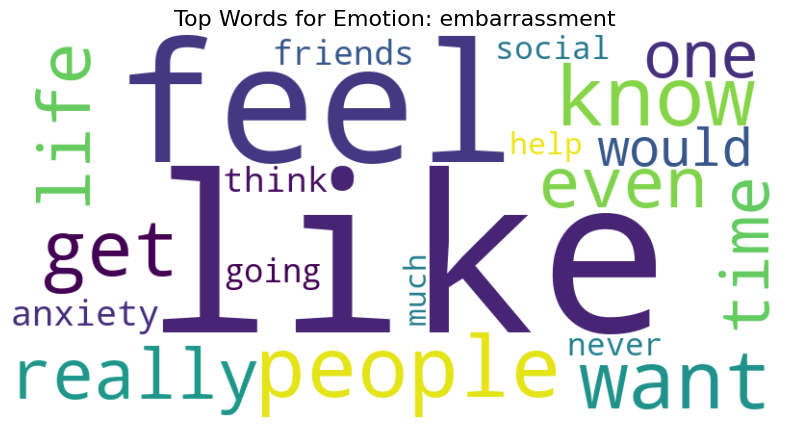

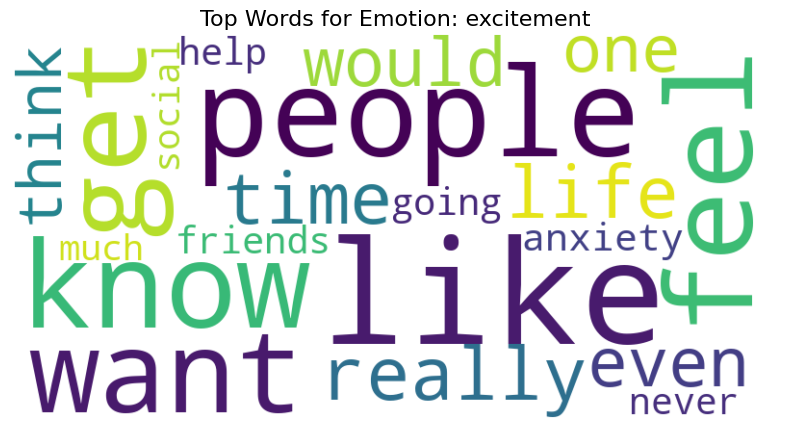

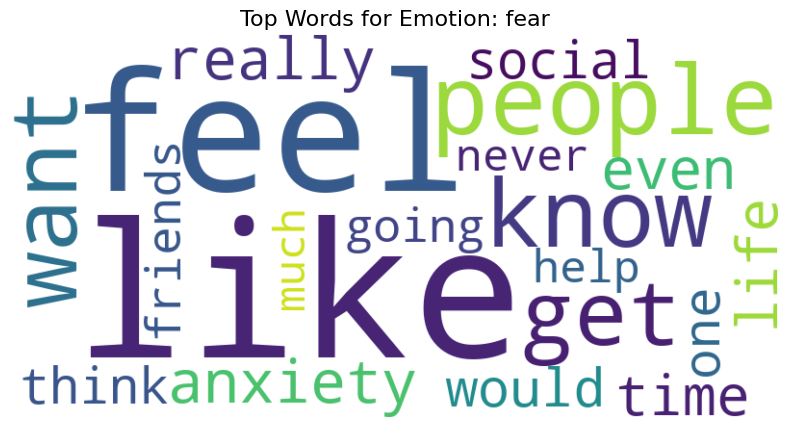

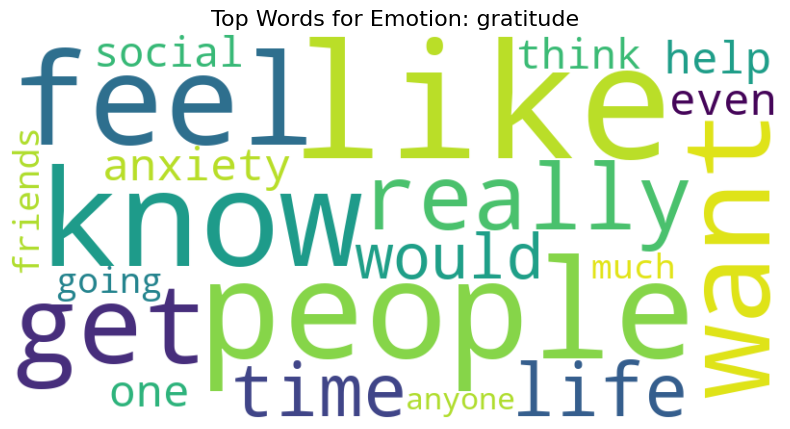

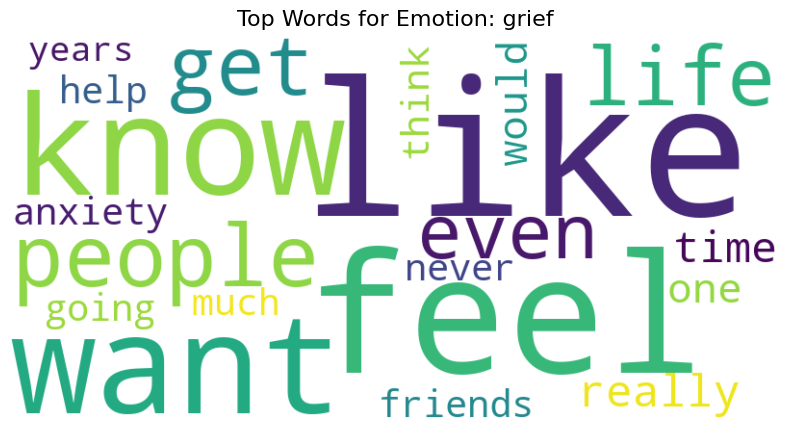

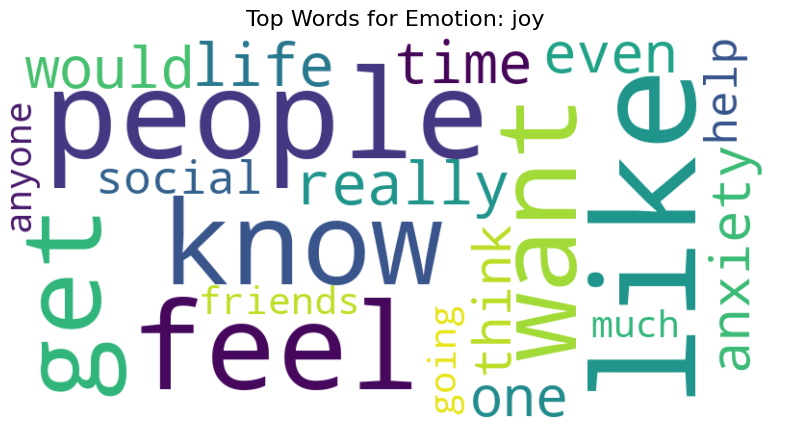

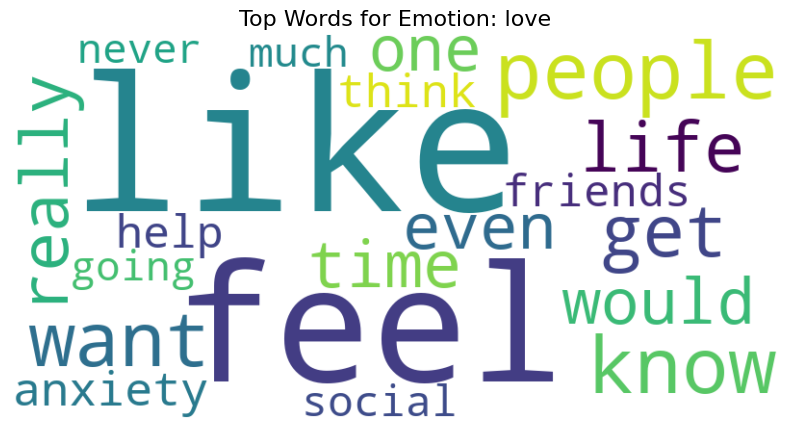

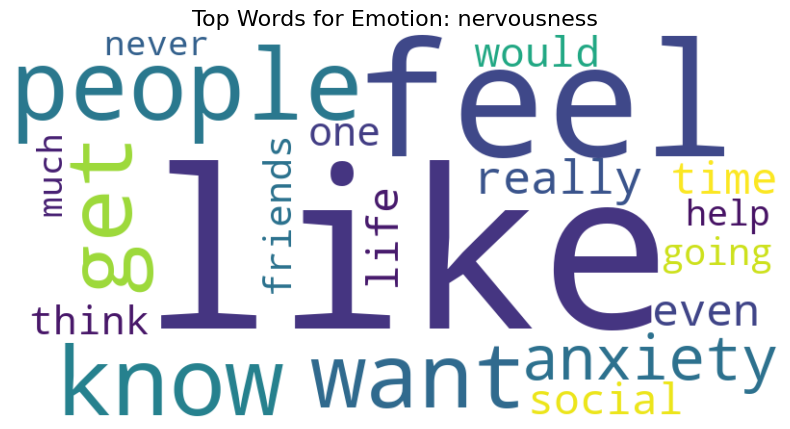

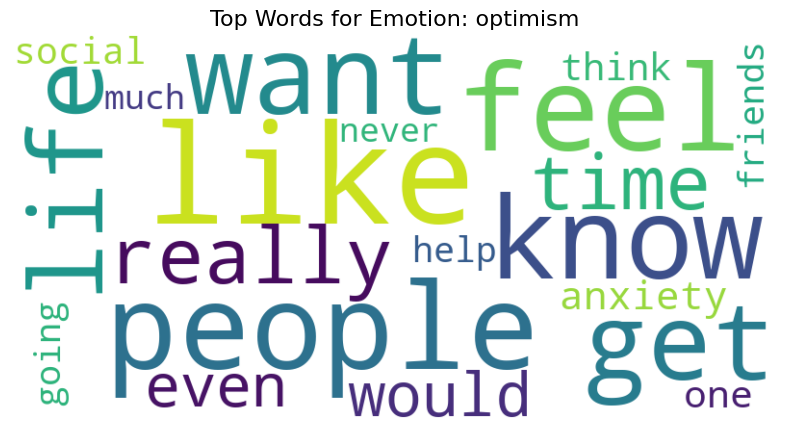

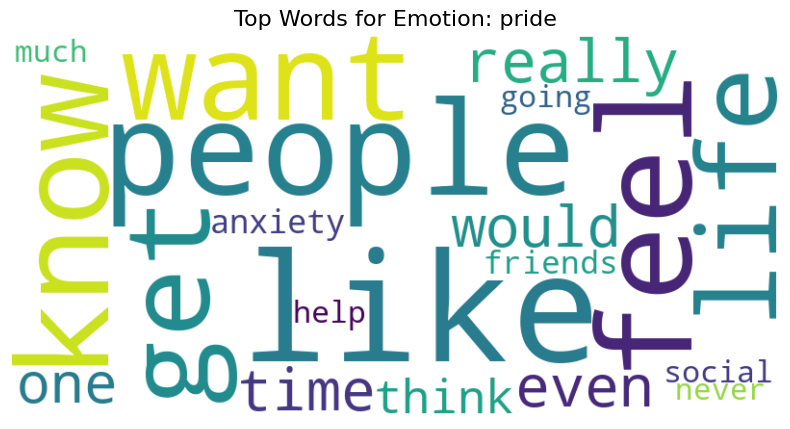

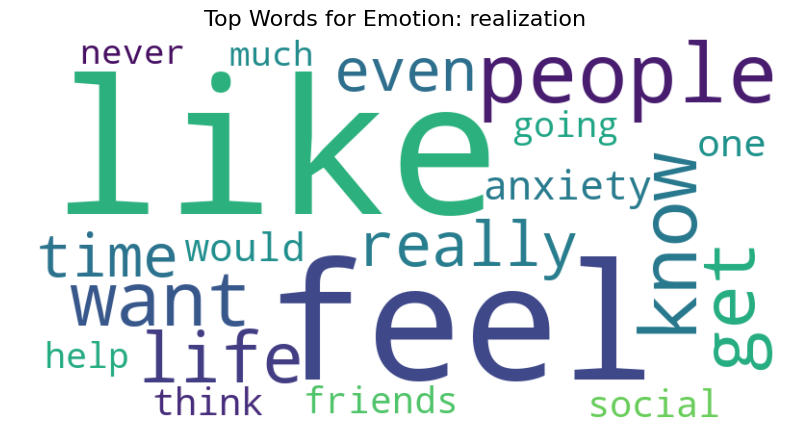

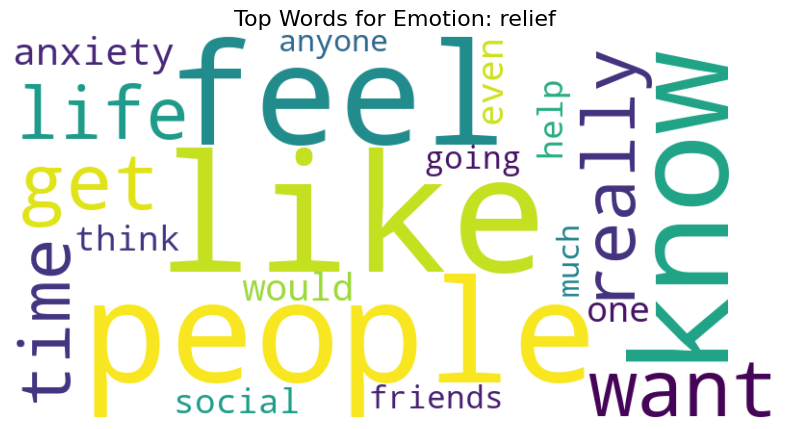

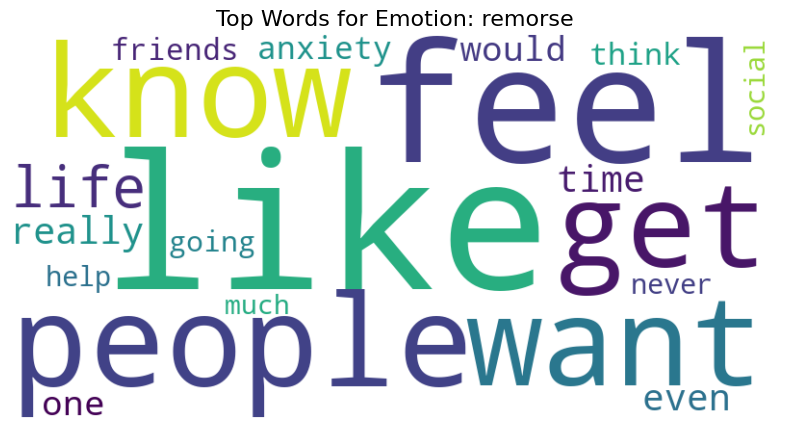

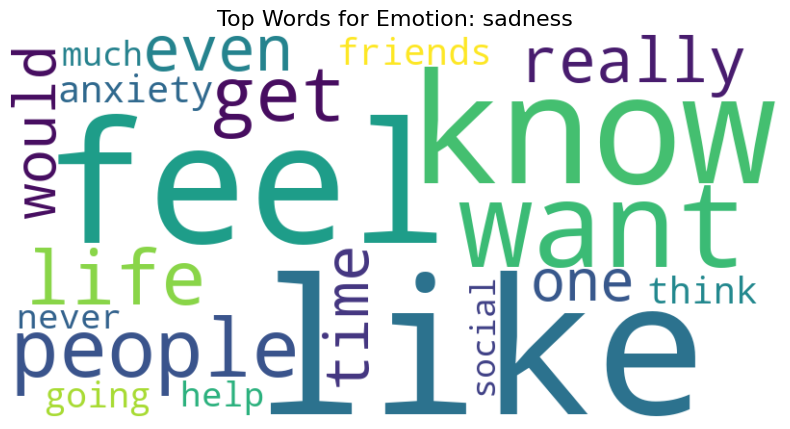

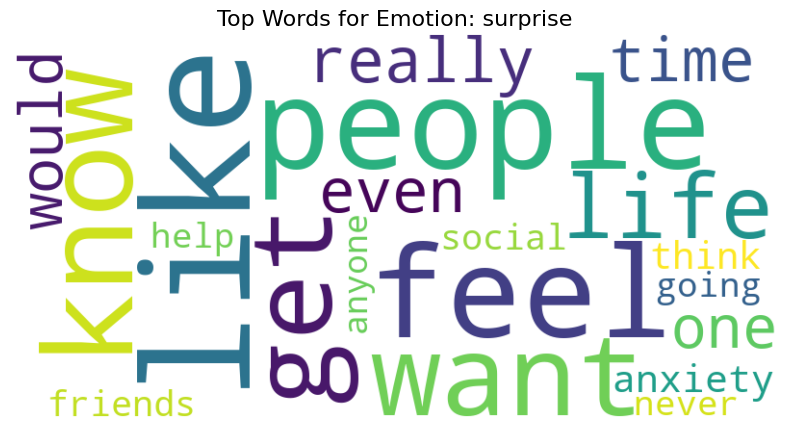

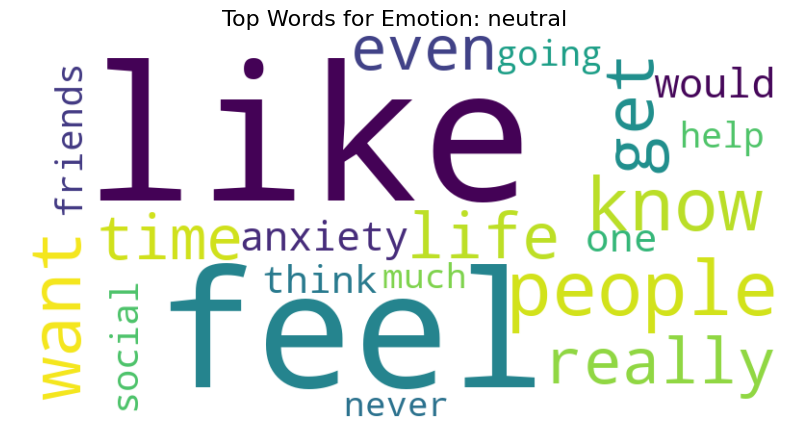

In [20]:
for emotion, words in emotion_top_words.items():
    freq_dict = {w: c for w, c in words}

    wc = WordCloud(width=800, height=400, background_color="white")
    wc = wc.generate_from_frequencies(freq_dict)

    plt.figure(figsize=(10,5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Top Words for Emotion: {emotion}", fontsize=16)
    plt.show()

In [21]:
df_subset

subreddit            author        date  \
27644  socialanxiety        SyrahIsFat  2020/01/01   
27645  socialanxiety  FuckAUsername420  2020/01/01   
27646  socialanxiety         blakppuch  2020/01/01   
27647  socialanxiety            Jothic  2020/01/01   
27648  socialanxiety    martellen14466  2020/01/01   
...              ...               ...         ...   
43812   suicidewatch    imhollowinside  2018/11/04   
43813   suicidewatch    RICEeatingFACE  2018/11/04   
43814   suicidewatch      Sethpai-Chan  2018/11/04   
43815   suicidewatch         ScatterF1  2018/11/04   
43816   suicidewatch      Tangerine117  2018/11/04   

                                                    post  admiration  \
27644  sertraline For anxiety Hi basically I have rea...    0.170258   
27645  Do you guys ever feel like you're a different ...    0.465041   
27646  We had visitors and it wasn’t that bad. Over t...    0.327560   
27647  I have social anxiety and anger issues I’ve be...    0.131844   
27648  New year new me HAPPY NEW YEAR!!!\n\n         ...    0.231275   
...                                                  ...         ...   
43812  Im hollow inside hello this was originally a t...    0.176284   
43813  Suicide Date set I'm 26. Been experiencing dep...    0.183907   
43814  I tried my best I really did. I did everything...    0.168648   
43815  Teetering on the edge I'm so close to just bei...    0.216291   
43816  I’ve got a problem that I can’t fix Cause I do...    0.187138   

       amusement     anger  annoyance  approval    caring  ...      love  \
27644   0.112826  0.209765   0.427590  0.427473  0.573860  ...  0.112382   
27645   0.345631  0.236746   0.529976  0.515053  0.725153  ...  0.225023   
27646   0.315480  0.252509   0.461624  0.555428  0.568077  ...  0.173197   
27647   0.082296  0.588108   0.586870  0.445694  0.472678  ...  0.075001   
27648   0.250318  0.174902   0.326826  0.508116  0.639660  ...  0.219618   
...          ...       ...        ...       ...       ...  ...       ...   
43812   0.157556  0.441755   0.641387  0.542654  0.495704  ...  0.105390   
43813   0.122469  0.344501   0.468341  0.610809  0.452674  ...  0.126804   
43814   0.098809  0.375866   0.497546  0.409189  0.561160  ...  0.174408   
43815   0.173951  0.659480   0.576180  0.529771  0.400897  ...  0.190090   
43816   0.238193  0.503198   0.646933  0.379134  0.428302  ...  0.139071   

       nervousness  optimism     pride  realization    relief   remorse  \
27644     0.940980  0.125716  0.165292     0.486689  0.215284  0.470146   
27645     0.397530  0.361793  0.472100     0.707752  0.510019  0.426507   
27646     0.878878  0.213920  0.271182     0.419213  0.290529  0.603428   
27647     0.900948  0.144398  0.211303     0.498434  0.146028  0.672971   
27648     0.937274  0.360400  0.254530     0.416188  0.362162  0.435537   
...            ...       ...       ...          ...       ...       ...   
43812     0.412819  0.161582  0.228608     0.376790  0.176818  0.694423   
43813     0.378065  0.163740  0.203696     0.374488  0.169020  0.706457   
43814     0.378143  0.244538  0.310942     0.566134  0.221787  0.883227   
43815     0.604644  0.170767  0.275559     0.354149  0.188642  0.586957   
43816     0.274697  0.262994  0.301149     0.629111  0.384364  0.591203   

        sadness  surprise   neutral  
27644  0.506701  0.297525  0.323210  
27645  0.336150  0.432141  0.816404  
27646  0.410289  0.491972  0.416410  
27647  0.464025  0.295126  0.318911  
27648  0.320053  0.338084  0.309713  
...         ...       ...       ...  
43812  0.831112  0.431478  0.354123  
43813  0.880339  0.448022  0.338266  
43814  0.863489  0.378687  0.422404  
43815  0.674981  0.327434  0.291801  
43816  0.696781  0.390430  0.580351  

[10000 rows x 32 columns]

In [22]:
df_subset.to_csv("../Datasets/CLpsych/data/combined-data/goemotions_10k.csv", index=False)


In [25]:
risk_model_name = "sentinet/suicidality"  # e.g., "username/clpsych-suicide-roberta" once you pick one
risk_tokenizer = AutoTokenizer.from_pretrained(risk_model_name)
risk_model = AutoModelForSequenceClassification.from_pretrained(risk_model_name)

torch.set_grad_enabled(False)

risk_id2label = risk_model.config.id2label  # e.g. {0: "none", 1: "low", 2: "moderate", 3: "high"}

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


tokenizer_config.json:   0%|          | 0.00/317 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/848 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

In [33]:
def predict_risk(text: str):
    inputs = risk_tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        max_length=256
    )
    outputs = risk_model(**inputs)
    logits = outputs.logits.squeeze(0)
    probs = F.softmax(logits, dim=-1).tolist()

    # Map to labels
    risk_scores = {
        risk_id2label[i]: probs[i] for i in range(len(probs))
    }
    # Highest-probability class
    risk_level = max(risk_scores, key=risk_scores.get)

    return risk_level, risk_scores

In [34]:
# Get labels directly from the model (e.g. {0: 'non-suicidal', 1: 'suicidal'})
risk_id2label = risk_model.config.id2label

# Create columns dynamically based on model labels
df_subset["risk_label"] = None

for label in risk_id2label.values():
    df_subset[f"risk_{label.replace('-', '_')}"] = 0.0  # sanitize for pandas


# Run prediction loop
for idx, row in df_subset.iterrows():
    if idx % 500 == 0:
        print(f"Processing risk for row {idx} / {len(df_subset)}")

    level, scores = predict_risk(row["post"])

    # Save the discrete label (e.g. "non-suicidal")
    df_subset.at[idx, "risk_label"] = level

    # Save each probability
    for label, score in scores.items():
        safe_label = label.replace('-', '_')  # handle labels like "non-suicidal"
        df_subset.at[idx, f"risk_{safe_label}"] = score

df_subset.head()

Processing risk for row 28000 / 10000
Processing risk for row 28500 / 10000
Processing risk for row 29000 / 10000
Processing risk for row 29500 / 10000
Processing risk for row 30000 / 10000
Processing risk for row 30500 / 10000
Processing risk for row 31000 / 10000
Processing risk for row 36500 / 10000
Processing risk for row 37000 / 10000
Processing risk for row 37500 / 10000
Processing risk for row 39000 / 10000
Processing risk for row 39500 / 10000
Processing risk for row 40000 / 10000
Processing risk for row 40500 / 10000
Processing risk for row 41000 / 10000
Processing risk for row 41500 / 10000
Processing risk for row 42000 / 10000
Processing risk for row 42500 / 10000
Processing risk for row 43000 / 10000
Processing risk for row 43500 / 10000


subreddit            author        date  \
27644  socialanxiety        SyrahIsFat  2020/01/01   
27645  socialanxiety  FuckAUsername420  2020/01/01   
27646  socialanxiety         blakppuch  2020/01/01   
27647  socialanxiety            Jothic  2020/01/01   
27648  socialanxiety    martellen14466  2020/01/01   

                                                    post  admiration  \
27644  sertraline For anxiety Hi basically I have rea...    0.170258   
27645  Do you guys ever feel like you're a different ...    0.465041   
27646  We had visitors and it wasn’t that bad. Over t...    0.327560   
27647  I have social anxiety and anger issues I’ve be...    0.131844   
27648  New year new me HAPPY NEW YEAR!!!\n\n         ...    0.231275   

       amusement     anger  annoyance  approval    caring  ...     pride  \
27644   0.112826  0.209765   0.427590  0.427473  0.573860  ...  0.165292   
27645   0.345631  0.236746   0.529976  0.515053  0.725153  ...  0.472100   
27646   0.315480  0.252509   0.461624  0.555428  0.568077  ...  0.271182   
27647   0.082296  0.588108   0.586870  0.445694  0.472678  ...  0.211303   
27648   0.250318  0.174902   0.326826  0.508116  0.639660  ...  0.254530   

       realization    relief   remorse   sadness  surprise   neutral  \
27644     0.486689  0.215284  0.470146  0.506701  0.297525  0.323210   
27645     0.707752  0.510019  0.426507  0.336150  0.432141  0.816404   
27646     0.419213  0.290529  0.603428  0.410289  0.491972  0.416410   
27647     0.498434  0.146028  0.672971  0.464025  0.295126  0.318911   
27648     0.416188  0.362162  0.435537  0.320053  0.338084  0.309713   

       risk_label  risk_LABEL_0  risk_LABEL_1  
27644     LABEL_0      0.877541      0.122459  
27645     LABEL_0      0.993075      0.006925  
27646     LABEL_0      0.847472      0.152527  
27647     LABEL_0      0.973255      0.026745  
27648     LABEL_0      0.994486      0.005514  

[5 rows x 35 columns]

In [35]:
df_subset

subreddit            author        date  \
27644  socialanxiety        SyrahIsFat  2020/01/01   
27645  socialanxiety  FuckAUsername420  2020/01/01   
27646  socialanxiety         blakppuch  2020/01/01   
27647  socialanxiety            Jothic  2020/01/01   
27648  socialanxiety    martellen14466  2020/01/01   
...              ...               ...         ...   
43812   suicidewatch    imhollowinside  2018/11/04   
43813   suicidewatch    RICEeatingFACE  2018/11/04   
43814   suicidewatch      Sethpai-Chan  2018/11/04   
43815   suicidewatch         ScatterF1  2018/11/04   
43816   suicidewatch      Tangerine117  2018/11/04   

                                                    post  admiration  \
27644  sertraline For anxiety Hi basically I have rea...    0.170258   
27645  Do you guys ever feel like you're a different ...    0.465041   
27646  We had visitors and it wasn’t that bad. Over t...    0.327560   
27647  I have social anxiety and anger issues I’ve be...    0.131844   
27648  New year new me HAPPY NEW YEAR!!!\n\n         ...    0.231275   
...                                                  ...         ...   
43812  Im hollow inside hello this was originally a t...    0.176284   
43813  Suicide Date set I'm 26. Been experiencing dep...    0.183907   
43814  I tried my best I really did. I did everything...    0.168648   
43815  Teetering on the edge I'm so close to just bei...    0.216291   
43816  I’ve got a problem that I can’t fix Cause I do...    0.187138   

       amusement     anger  annoyance  approval    caring  ...     pride  \
27644   0.112826  0.209765   0.427590  0.427473  0.573860  ...  0.165292   
27645   0.345631  0.236746   0.529976  0.515053  0.725153  ...  0.472100   
27646   0.315480  0.252509   0.461624  0.555428  0.568077  ...  0.271182   
27647   0.082296  0.588108   0.586870  0.445694  0.472678  ...  0.211303   
27648   0.250318  0.174902   0.326826  0.508116  0.639660  ...  0.254530   
...          ...       ...        ...       ...       ...  ...       ...   
43812   0.157556  0.441755   0.641387  0.542654  0.495704  ...  0.228608   
43813   0.122469  0.344501   0.468341  0.610809  0.452674  ...  0.203696   
43814   0.098809  0.375866   0.497546  0.409189  0.561160  ...  0.310942   
43815   0.173951  0.659480   0.576180  0.529771  0.400897  ...  0.275559   
43816   0.238193  0.503198   0.646933  0.379134  0.428302  ...  0.301149   

       realization    relief   remorse   sadness  surprise   neutral  \
27644     0.486689  0.215284  0.470146  0.506701  0.297525  0.323210   
27645     0.707752  0.510019  0.426507  0.336150  0.432141  0.816404   
27646     0.419213  0.290529  0.603428  0.410289  0.491972  0.416410   
27647     0.498434  0.146028  0.672971  0.464025  0.295126  0.318911   
27648     0.416188  0.362162  0.435537  0.320053  0.338084  0.309713   
...            ...       ...       ...       ...       ...       ...   
43812     0.376790  0.176818  0.694423  0.831112  0.431478  0.354123   
43813     0.374488  0.169020  0.706457  0.880339  0.448022  0.338266   
43814     0.566134  0.221787  0.883227  0.863489  0.378687  0.422404   
43815     0.354149  0.188642  0.586957  0.674981  0.327434  0.291801   
43816     0.629111  0.384364  0.591203  0.696781  0.390430  0.580351   

       risk_label  risk_LABEL_0  risk_LABEL_1  
27644     LABEL_0      0.877541      0.122459  
27645     LABEL_0      0.993075      0.006925  
27646     LABEL_0      0.847472      0.152527  
27647     LABEL_0      0.973255      0.026745  
27648     LABEL_0      0.994486      0.005514  
...           ...           ...           ...  
43812     LABEL_1      0.021187      0.978813  
43813     LABEL_1      0.001313      0.998687  
43814     LABEL_1      0.002044      0.997956  
43815     LABEL_1      0.003870      0.996130  
43816     LABEL_1      0.025861      0.974139  

[10000 rows x 35 columns]

In [37]:
df_subset.to_csv("../Datasets/CLpsych/data/combined-data/goemotions_10k.csv", index=False)
